In [1]:
# IMPORT THE MODULES NEEDED
import os
import glob
import math
import datetime
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.python.keras.utils import losses_utils
#import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
from sklearn.preprocessing import normalize
from classification_models.tfkeras import Classifiers

In [2]:
## Define the parameters of the network and the save/log/data directories
# Change parameters here...
sizex = 500
sizey = 500
sizez = 3
rand_seed = 666
num_datasets = -1
batch_size = 32 * 4
nb_epochs = 150
validation_ratio = 0.2
ds_size = 405
buf_size = ds_size*2

# Parameter to also use the images with the dust rendered
use_dust = False

log_dir = "logs/"
os.makedirs(log_dir, exist_ok=True)
data_dir = 'data/'


model_name = 'custom_model_2' + '_bs'+str(batch_size)
if use_dust: model_name += '_dust'

snapshot_weights = 'models/best_'+model_name+'.hdf5'
last_snapshot_weights = 'models/last_'+model_name+'.hdf5'
json_name = 'models/json_'+model_name+'.json'
trained_model = 'models/trained_'+model_name+'.h5'

In [3]:
# Define the custom loss function from the cosine similarity impleted in tensorflow
class myCosineSimilarity(tf.keras.losses.Loss):
    def __init__(self,
               axis=-1,
               reduction=losses_utils.ReductionV2.AUTO,
               name='myCosineSimilarity'):
        super(myCosineSimilarity, self).__init__(reduction=reduction, name=name)
        self._axis = axis
    
    def call(self, y_true, y_pred):
        cossim = lambda y, p_y: -1*tf.keras.backend.abs(tf.keras.losses.cosine_similarity(y, p_y, axis=self._axis))
        return cossim(y_true, y_pred)

In [4]:
strategy = tf.distribute.MirroredStrategy()
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# Defining the model in all the devices (GPU's) available
with strategy.scope():
    # Build the model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), strides=(2,2), activation='relu', input_shape=(sizex,sizey,sizez)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(1,1)),
        tf.keras.layers.Conv2D(filters=16, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=16, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(1,1)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(2, activation='softmax')  ])
    
    # Use existing best weights if available...
    if os.path.isfile(last_snapshot_weights):
        print('loaded weights')
        model.load_weights(last_snapshot_weights)
    
    # Compile the model specifying the optimazer (sgd) and the custom loss function and other metrics
    model.compile(optimizer= tf.keras.optimizers.SGD(),
                  loss= myCosineSimilarity(), metrics=[tf.keras.losses.cosine_similarity,
                                                       tf.keras.metrics.mean_absolute_error,])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Num GPUs Available:  4
Number of devices: 4
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensor

In [5]:
# See a sumary of the model with all the layers and parameters
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 248, 248, 32)      2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 248, 248, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 246, 246, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 246, 246, 16)      528       
_________________________________________________________________
batch_normalization_1 (Batch (None, 246, 246, 16)      64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 246, 246, 32)      4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 246, 246, 32)      1

In [6]:
# Collect all the .npz files
numpy_datasets = glob.glob(data_dir+'dataset*')

# load the data into a dictionary from npz files
data_dict = {}
for dataset in numpy_datasets[:num_datasets]:
    with np.load(dataset) as data:
        if 'y' in data_dict.keys():
            data_dict['x_dust']   = np.append( data_dict['x_dust'], data['x_dust'],axis=0)
            data_dict['x_nodust'] = np.append( data_dict['x_nodust'], data['x_nodust'],axis=0)
            data_dict['y']        = np.append( data_dict['y'], data['y'],axis=0)
            data_dict['ids']      = np.append( data_dict['ids'], data['id'],axis=0)
        else:
            data_dict['x_dust']   = data['x_dust']
            data_dict['x_nodust'] = data['x_nodust']
            data_dict['y']        = data['y']
            data_dict['ids']      = data['id']

In [7]:
# check the shape of the dictionary (100 images of 500x500x3 = 4 files of 25 images) before filtering
print(data_dict['x_nodust'].shape)

(895, 500, 500, 3)


In [8]:
#Filter the galaxies that have less than 1e10 solar masses
bad_ids = [[galaxy_id,i] for galaxy_id,i in zip(data_dict['ids'],range(len(data_dict['ids']))) if 'e09' in galaxy_id or 'e10' in galaxy_id ]
bad_ids = np.array(bad_ids)
remove_galaxies = np.array(bad_ids[:,1],dtype=int)
print('there are ', len(bad_ids), ' galaxies to remove')
#print(remove_galaxies)
filtered_dict = {}

for key in data_dict.keys():
    data_dict[key] = np.delete(data_dict[key],remove_galaxies, axis=0)
    
print('Still have ', len(data_dict['ids']), ' galaxies left')
# check that we have filtered the correct galaxies
print(data_dict['ids'][:5])
# check the shape of the dictionary after filtering
print("shape of image's array",data_dict['x_dust'].shape)
# check the shape of our dictionary in te labels entry
print("shape of the label's array",data_dict['y'].shape)

there are  490  galaxies to remove
Still have  405  galaxies left
['g4.90e11_x134_y286_z196' 'g4.90e11_x26_y285_z64'
 'g4.90e11_x239_y101_z98' 'g4.90e11_x170_y94_z15'
 'g4.90e11_x147_y176_z286']
shape of image's array (405, 500, 500, 3)
shape of the label's array (405, 3)


In [9]:
# computing the normaliced vectors in 3D
data_dict['y_norm'] = normalize(data_dict['y'], axis=1)

In [10]:
# Functions to do the augmentation
def random_flip_lr(image, label, seed=None):
    img = tf.image.random_flip_left_right(image, seed=seed)
    if tf.reduce_all(tf.equal(img,image)):
        label_f = label
    else:
        label_f = tf.convert_to_tensor([-label[0],label[1]])
    return (img, label_f)

def random_flip_ud(image, label, seed=None):
    img = tf.image.random_flip_up_down(image, seed=seed)
    if tf.reduce_all(tf.equal(img,image)):
        label_f = label
    else:
        label_f = tf.convert_to_tensor([label[0],-label[1]])
    return (img,label_f)


def random_rot(image, label, seed=None):
    number_of_intervalls = 24 # 15 deg steps
    
    rad = tf.random.uniform(shape=[1], minval=0, maxval=2*math.pi, dtype=tf.float32)
    rad = rad//(2*math.pi/number_of_intervalls) * (2*math.pi/number_of_intervalls)
    #rad = tf.math.multiply(deg, tf.constant(math.pi/180, dtype=tf.float32))
    img = tfa.image.rotate(image, rad, interpolation = 'BILINEAR')
    
    x = tf.math.multiply(tf.math.cos(-rad), label[0]) - tf.math.multiply(tf.math.sin(-rad), label[1])
    y = tf.math.multiply(tf.math.sin(-rad), label[0]) + tf.math.multiply(tf.math.cos(-rad), label[1])
    label_f = tf.reshape(tf.convert_to_tensor([x, y]), [2])
    return (img,label_f)

def augment(img, label):
    img_f,label_f = random_flip_lr(img,label)
    img_f,label_f = random_flip_ud(img_f,label_f)
    img_f,label_f = random_rot(img_f,label_f)
    return (img_f, label_f)

In [11]:
# Import the autotune option from TF
AUTO = tf.data.experimental.AUTOTUNE

# Defining the train and validation dataset from the existing dictionary, shufling and batching
# First we do the ones without dust, then if duts is activated we make it also with dust and mix both
input_ds_nodust = (
    tf.data.Dataset.from_tensor_slices((data_dict['x_nodust'].astype(np.float32),
                                        data_dict['y_norm'][:,:2].astype(np.float32)))
                    # Use seed to ensure we always have the same validation data set!
                   .shuffle(ds_size, seed = rand_seed, reshuffle_each_iteration = False))

# take a part of the dataset (we take all but there's the option to take just a part of it with the ds_size parameter)
input_ds_nodust = input_ds_nodust.take(ds_size)
# compute the val_size dataset in terms of the ds_size and the validation_ratio that we have
val_size = math.floor(ds_size * validation_ratio)

# cache and augment the dataset (THE ORDER IS IMPORTANT!!)
validation_ds_nodust_aug =  (input_ds_nodust.take(val_size).cache()
                            .map(augment, num_parallel_calls=AUTO))
train_ds_nodust_aug      =  (input_ds_nodust.skip(val_size).cache()
                            .map(augment, num_parallel_calls=AUTO))

# if dust is activated compute the dust datasets
if use_dust:
    input_ds_dust = (
        tf.data.Dataset.from_tensor_slices((data_dict['x_dust'].astype(np.float32),
                                            data_dict['y_norm'][:,:2].astype(np.float32)))
                       .shuffle(ds_size, seed = rand_seed, reshuffle_each_iteration = False))
    
    input_ds_dust = input_ds_dust.take(ds_size)
    validation_ds_dust_aug = (input_ds_dust.take(val_size).cache()
                              .map(augment, num_parallel_calls=AUTO))
    train_ds_dust_aug =  (input_ds_dust.skip(val_size).cache()
                          .map(augment, num_parallel_calls=AUTO))
    
    # concatenate both datasets (dust and no dust) and repeat the data and batch it
    train_ds = (train_ds_dust_aug.concatenate(train_ds_nodust_aug)
                    .shuffle(buffer_size=buf_size, reshuffle_each_iteration=True)
                    .repeat(48).batch(batch_size).prefetch(AUTO))
    validation_ds = (validation_ds_dust_aug.concatenate(validation_ds_nodust_aug)
                    .repeat(48).batch(batch_size).prefetch(AUTO))

else:
    # if dust is not activated compute the dataset from the nodust dataset and reapeat the data and batch it
    train_ds = (train_ds_nodust_aug
                    .shuffle(buffer_size=buf_size, reshuffle_each_iteration=True)
                    .repeat(48).batch(batch_size).prefetch(AUTO))
    validation_ds = (validation_ds_nodust_aug
                    .repeat(48).batch(batch_size).prefetch(AUTO))

# check all the datasets to see if they are correct
print(validation_ds_nodust_aug)
print(train_ds_nodust_aug)
print(validation_ds)
print(train_ds)

<ParallelMapDataset shapes: ((500, 500, 3), (2,)), types: (tf.float32, tf.float32)>
<ParallelMapDataset shapes: ((500, 500, 3), (2,)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 500, 500, 3), (None, 2)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 500, 500, 3), (None, 2)), types: (tf.float32, tf.float32)>


#### **cartesian label:** [0.01329762 0.50267255]

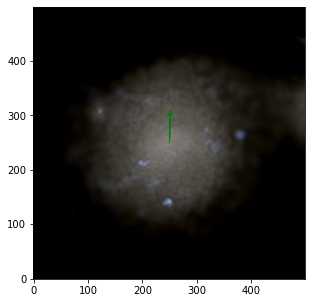

#### **cartesian label:** [0.8336932 0.1399445]

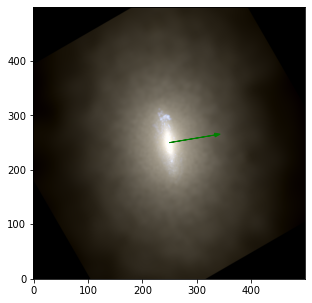

#### **cartesian label:** [ 0.04296982 -0.8104438 ]

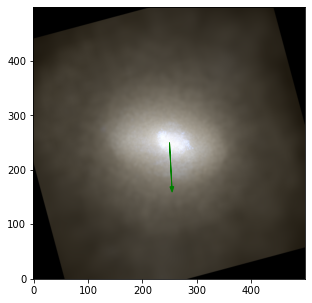

#### **cartesian label:** [-0.04918047 -0.03201973]

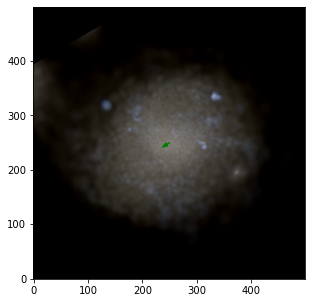

#### **cartesian label:** [ 0.11954587 -0.0890835 ]

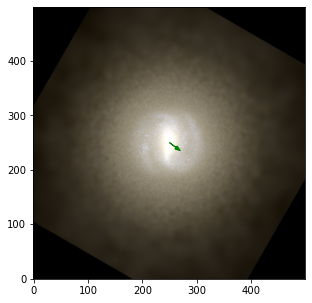

#### **cartesian label:** [-0.7184739  -0.13021168]

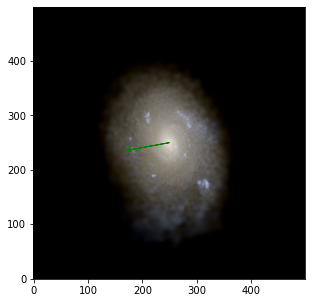

#### **cartesian label:** [-0.38894683  0.76978314]

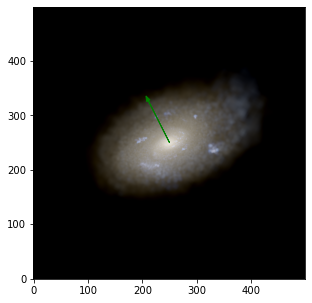

#### **cartesian label:** [-0.5599643 -0.5867982]

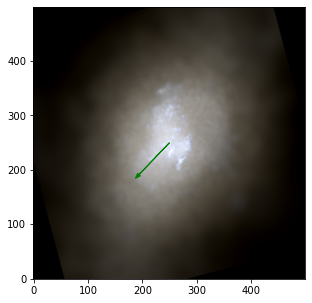

#### **cartesian label:** [ 0.7519088  -0.24039316]

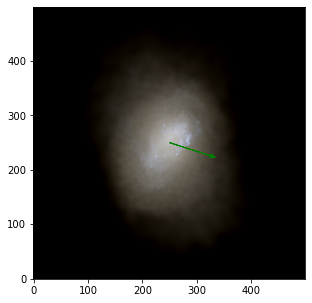

#### **cartesian label:** [-0.17370175  0.4214698 ]

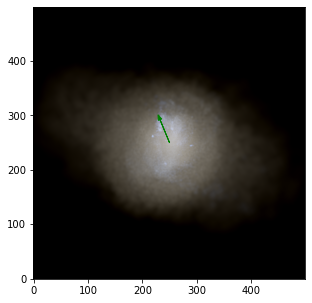

In [12]:
# function to visualice the data 
def viz(img, label, pred=np.array([0,0,0]), id=None):
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(img, cmap='gray', vmin=0, vmax=255,origin='lower')
    ax.arrow(250,250,100*label[0],100*label[1], head_width=7, head_length=10, fc='g', ec='g')
    if np.sum(np.abs(pred)) > 0: ax.arrow(250,250,100*pred[0],100*pred[1], head_width=7, head_length=10, fc='r', ec='r')
        
    display(Markdown("#### **cartesian label:** {}".format(label)))
    if np.sum(np.abs(pred)) > 0: display(Markdown("#### **cartesian prediction (x_y):** {}".format(pred)))
    if id: display(Markdown("#### **ID:** {}".format(id)))
    plt.show()

# visualice the data
for idx in range(1,5):
    elements = train_ds.take(idx)
    for elem in elements:
        viz(elem[0][idx], elem[1][idx])#, elem['y_revs'][idx], id=elem['ids'][idx])

In [13]:
# Launch tensorboard
%reload_ext tensorboard
%tensorboard --logdir {log_dir} --reload_multifile True --host 0.0.0.0 --port 6006

Reusing TensorBoard on port 6006 (pid 21445), started 0:11:28 ago. (Use '!kill 21445' to kill it.)

In [14]:
# serialize model to JSON for latter infernce
model_json = model.to_json()
with open(json_name, "w") as json_file:
    json_file.write(model_json)

In [15]:
# For tensorboard to save the models
log_dir_s = log_dir + model_name
os.makedirs(log_dir_s, exist_ok=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir_s, histogram_freq=1, update_freq='batch', profile_batch=0)

#define the learning rate scheduler
def scheduler(epoch, lr):
    if epoch == 200:
        return lr #/ 100
    else:
        return lr

# Checkpointing
checkpointer_1 = tf.keras.callbacks.ModelCheckpoint(filepath=snapshot_weights,
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True)
checkpointer_2 = tf.keras.callbacks.ModelCheckpoint(filepath=last_snapshot_weights,
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=False)
LearningRateScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

callbacks = [
    tensorboard_callback,
    checkpointer_1,
    checkpointer_2,
    LearningRateScheduler,
]

# Fit the model with the training and validation data, number of epochs and callbacks
model.fit(
    train_ds,
    validation_data = validation_ds,
    epochs = nb_epochs,
    callbacks = callbacks,)

Epoch 1/150
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
INFO:tensorflow:batch_all_reduce: 20 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 20 all-reduces with algorithm = nccl, num_packs = 1
122/122 [==============================] - ETA: 0s - loss: -0.7143 - cosine_similarity: 0.0138 - mean_absolute_error: 0.7118
Epoch 00001: val_loss improved from inf to -0.63525, saving model to models/best_custom_model_2_bs128.hdf5

Epoch 00001: saving model to models/last_custom_model_2_bs128.hdf5
122/122 [==============================] - 140s 1s/step - loss: -0.7143 - cosine_similarity: 0.0138 - mean_absolute_error: 0.7118 - val_loss: -0.6352 - val_cosine_similarity: -0.0062 - val_mean_absolute_error: 0.7344
Epoch 2/150
122/122 [==============================] - ETA: 0s - loss: -0.7392 - cosine_similarity: -0.0052 - mean_absolute_error: 0.6953
Epoch 00002: val_loss improved from -0.63525 to -0.72602, saving model to model

In [16]:
#save the last weights of the model
model.save(trained_model)

In [17]:
# taking samples from the validation dataset and evaluating the model
val_ex, = validation_ds.take(1)
train_ex, = train_ds.take(1)

images_v, labels_v = val_ex[0], val_ex[1]
images_t, labels_t = train_ex[0], train_ex[1]

#making the predictions for the taken images
outputs_v = model.predict(images_v)
outputs_t = model.predict(images_t)

#### **cartesian label:** [-0.15236741 -0.48415893]

#### **cartesian prediction (x_y):** [1.000000e+00 9.408082e-12]

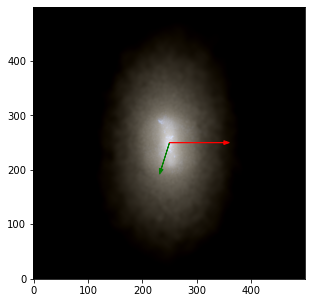

#### **cartesian label:** [0.02936645 0.99557835]

#### **cartesian prediction (x_y):** [0. 1.]

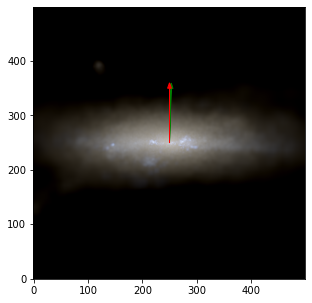

#### **cartesian label:** [ 0.14808032 -0.07522109]

#### **cartesian prediction (x_y):** [0.98920023 0.01079979]

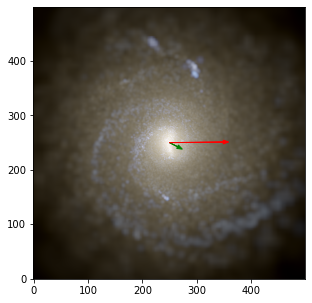

#### **cartesian label:** [ 0.6200029 -0.736109 ]

#### **cartesian prediction (x_y):** [0. 1.]

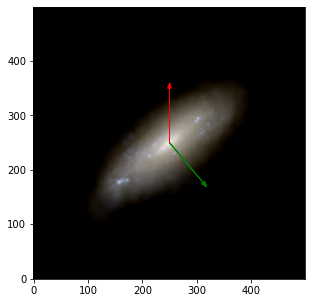

#### **cartesian label:** [-0.9128707  -0.40096402]

#### **cartesian prediction (x_y):** [0.8638108  0.13618927]

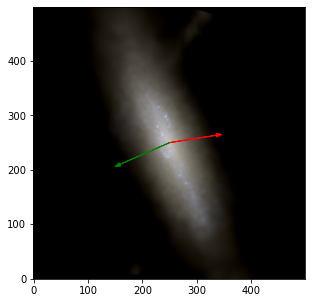

In [18]:
# visualicing the results
for img,label,pred,i in zip(images_t, labels_t, outputs_t,range(5)):
    viz(img, label, pred)

#### **cartesian label:** [0.856485   0.48939443]

#### **cartesian prediction (x_y):** [9.999999e-01 7.860013e-08]

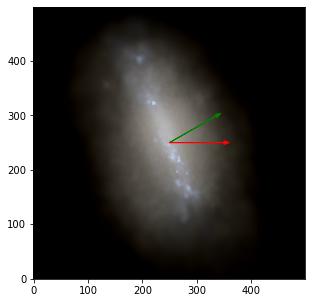

#### **cartesian label:** [-0.58362055  0.6803069 ]

#### **cartesian prediction (x_y):** [0. 1.]

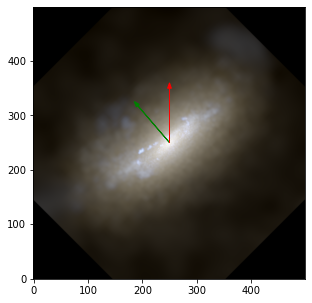

#### **cartesian label:** [ 0.36468253 -0.31745943]

#### **cartesian prediction (x_y):** [8.7645974e-05 9.9991238e-01]

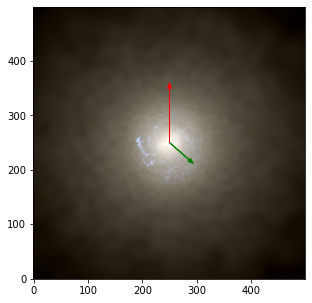

#### **cartesian label:** [0.10039221 0.6137638 ]

#### **cartesian prediction (x_y):** [5.640219e-38 1.000000e+00]

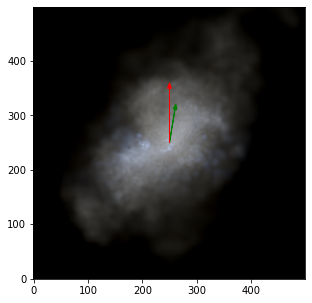

#### **cartesian label:** [0.69345754 0.1714363 ]

#### **cartesian prediction (x_y):** [2.1745562e-05 9.9997830e-01]

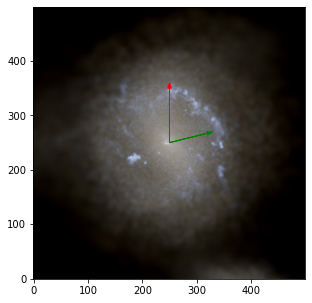

In [19]:
for img,label,pred,i in zip(images_v, labels_v, outputs_v,range(5)):
    viz(img, label, pred)